# Exp_5: The aim is to build your own Image dataset and design a Convoluional Neural Network (CNN) classifier. Train and test the model. Calculate the trainable parameters manually and check with the model. Also calculate the performance metrics by building the confusion matrix. Calculate Accuracy, Precision, recall and F1 score.

In [ ]:
# Read the dataset

In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.transforms import Compose, Resize, ToTensor
import os
from PIL import Image

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),          # Convert to tensor
])

In [ ]:
# Define dataset directories
data_dir = "MY_DATASET_EXP5" #"path/to/your/dataset" Change this to your dataset path
train_dir = f"{data_dir}/train"
test_dir = f"{data_dir}/test"

In [ ]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

In [ ]:
# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [ ]:
# Get class names
class_names = train_dataset.classes
print(f"Class Names: {class_names}")

In [ ]:
# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=ToTensor())
test_dataset = ImageFolder(root=test_dir, transform=ToTensor())

# Display dataset sizes
print(f"Number of training images: {len(train_dataset)}")
print(f"Number of testing images: {len(test_dataset)}")

# Display class-wise distribution
train_class_counts = {train_dataset.classes[i]: 0 for i in range(len(train_dataset.classes))}
test_class_counts = {test_dataset.classes[i]: 0 for i in range(len(test_dataset.classes))}

# Dictionary to store image sizes
train_image_sizes = []
test_image_sizes = []

# Get image sizes and class distributions
for img_path, label in train_dataset.imgs:
    train_class_counts[train_dataset.classes[label]] += 1
    with Image.open(img_path) as img:
        train_image_sizes.append(img.size)  # (width, height)

for img_path, label in test_dataset.imgs:
    test_class_counts[test_dataset.classes[label]] += 1
    with Image.open(img_path) as img:
        test_image_sizes.append(img.size)  # (width, height)

# Unique image sizes in the dataset
unique_train_sizes = set(train_image_sizes)
unique_test_sizes = set(test_image_sizes)

print("\nClass-wise distribution (Train):")
for class_name, count in train_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nClass-wise distribution (Test):")
for class_name, count in test_class_counts.items():
    print(f"{class_name}: {count} images")

print("\nUnique image sizes in Training Set:")
for size in unique_train_sizes:
    print(f"Size: {size[0]}x{size[1]} (Width x Height)")

print("\nUnique image sizes in Testing Set:")
for size in unique_test_sizes:
    print(f"Size: {size[0]}x{size[1]} (Width x Height)")


In [ ]:
# Get a batch of images from train_loader
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Print image dimensions
print(f"Image batch shape: {images.shape}")  # Shape: (batch_size, channels, height, width)

# Print individual image dimensions
for i in range(len(images)):
    print(f"Image {i+1} size: {images[i].shape[1]}x{images[i].shape[2]} (Height x Width)")

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directories
data_dir = "MY_DATASET_EXP5"  # Change this to your dataset path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transformations (Resize to prevent memory issues)
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize all images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for stability
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get number of classes
num_classes = len(train_dataset.classes)
print(f"Number of classes: {num_classes}")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)  # Adjust size based on input image size
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 30
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

# Testing loop
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

test_accuracy = 100 * correct / total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Using device: cuda
Number of classes: 3
Epoch [1/30], Loss: 1.8301, Accuracy: 40.00%
Epoch [2/30], Loss: 1.1300, Accuracy: 33.33%
Epoch [3/30], Loss: 1.1038, Accuracy: 40.00%
Epoch [4/30], Loss: 1.0756, Accuracy: 43.33%
Epoch [5/30], Loss: 1.0354, Accuracy: 50.00%
Epoch [6/30], Loss: 1.0140, Accuracy: 50.00%
Epoch [7/30], Loss: 0.9081, Accuracy: 53.33%
Epoch [8/30], Loss: 0.8014, Accuracy: 73.33%
Epoch [9/30], Loss: 0.6704, Accuracy: 76.67%
Epoch [10/30], Loss: 0.5183, Accuracy: 80.00%
Epoch [11/30], Loss: 0.5687, Accuracy: 76.67%
Epoch [12/30], Loss: 0.3122, Accuracy: 86.67%
Epoch [13/30], Loss: 0.3696, Accuracy: 93.33%
Epoch [14/30], Loss: 0.2904, Accuracy: 83.33%
Epoch [15/30], Loss: 0.3140, Accuracy: 93.33%
Epoch [16/30], Loss: 0.2914, Accuracy: 86.67%
Epoch [17/30], Loss: 0.2451, Accuracy: 93.33%
Epoch [18/30], Loss: 0.1612, Accuracy: 96.67%
Epoch [19/30], Loss: 0.2049, Accuracy: 96.67%
Epoch [20/30], Loss: 0.1372, Accuracy: 96.67%
Epoch [21/30], Loss: 0.0936, Accuracy: 100.00%
Ep

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directories
data_dir = "MY_DATASET_EXP5"  # Change this to your dataset path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize images to 128x128
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize for stability
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform)
test_dataset = ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 16 * 16, 256)
        self.fc2 = nn.Linear(256, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = self.pool(self.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the feature maps
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = SimpleCNN(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.00001)

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

# Testing loop
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report (Precision, Recall, F1-score)
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Convert labels to one-hot encoding for ROC curve (needed for multi-class classification)
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
all_probs = np.array(all_probs)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()

Using device: cuda
Classes: ['cats', 'dogs', 'serval']


RuntimeError: mat1 and mat2 shapes cannot be multiplied (16x131072 and 32768x256)

Using device: cuda
Classes: ['cats', 'dogs', 'serval']
Epoch [1/100], Loss: 8.3119, Accuracy: 36.67%
Epoch [2/100], Loss: 4.9158, Accuracy: 40.00%
Epoch [3/100], Loss: 8.2044, Accuracy: 26.67%
Epoch [4/100], Loss: 6.8904, Accuracy: 46.67%
Epoch [5/100], Loss: 6.8006, Accuracy: 33.33%
Epoch [6/100], Loss: 5.5239, Accuracy: 40.00%
Epoch [7/100], Loss: 1.9525, Accuracy: 53.33%
Epoch [8/100], Loss: 4.0214, Accuracy: 33.33%
Epoch [9/100], Loss: 2.7580, Accuracy: 50.00%
Epoch [10/100], Loss: 2.5007, Accuracy: 50.00%
Epoch [11/100], Loss: 2.7267, Accuracy: 56.67%
Epoch [12/100], Loss: 1.5777, Accuracy: 66.67%
Epoch [13/100], Loss: 1.0773, Accuracy: 66.67%
Epoch [14/100], Loss: 1.3647, Accuracy: 70.00%
Epoch [15/100], Loss: 0.8697, Accuracy: 73.33%
Epoch [16/100], Loss: 1.5610, Accuracy: 66.67%
Epoch [17/100], Loss: 1.0310, Accuracy: 73.33%
Epoch [18/100], Loss: 1.9830, Accuracy: 46.67%
Epoch [19/100], Loss: 1.1099, Accuracy: 76.67%
Epoch [20/100], Loss: 1.0917, Accuracy: 80.00%
Epoch [21/100]

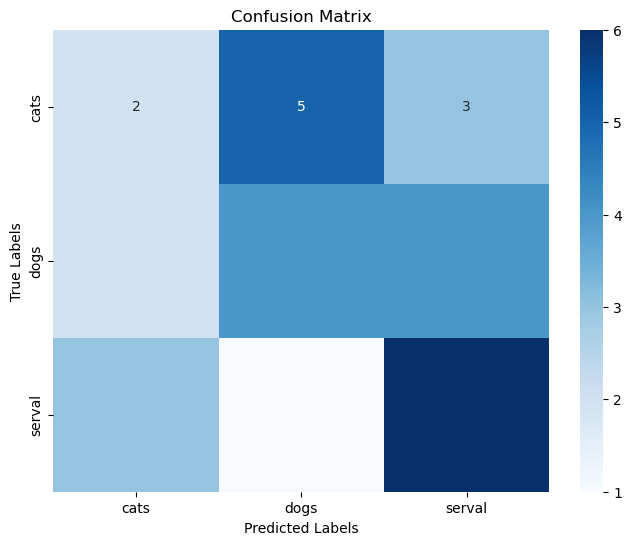


Classification Report:
               precision    recall  f1-score   support

        cats       0.29      0.20      0.24        10
        dogs       0.40      0.40      0.40        10
      serval       0.46      0.60      0.52        10

    accuracy                           0.40        30
   macro avg       0.38      0.40      0.39        30
weighted avg       0.38      0.40      0.39        30



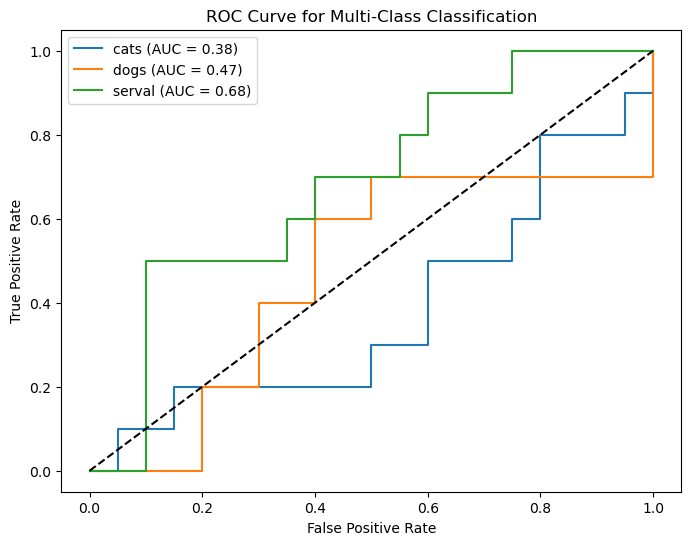

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

# Select device (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define dataset directories
data_dir = "MY_DATASET_EXP5"  # Change this to your dataset path
train_dir = os.path.join(data_dir, "train")
test_dir = os.path.join(data_dir, "test")

# Define transformations for Data Augmentation
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

transform_test = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Load datasets
train_dataset = ImageFolder(root=train_dir, transform=transform_train)
test_dataset = ImageFolder(root=test_dir, transform=transform_test)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=2, shuffle=False)

# Get number of classes
num_classes = len(train_dataset.classes)
class_names = train_dataset.classes
print(f"Classes: {class_names}")

# Define the CNN model for 256x256 images
class CNN_256(nn.Module):
    def __init__(self, num_classes):
        super(CNN_256, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 32 * 32, 512)  # Adjusted for 256x256 input
        self.fc2 = nn.Linear(512, num_classes)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(nn.ReLU()(self.bn1(self.conv1(x))))
        x = self.pool(nn.ReLU()(self.bn2(self.conv2(x))))
        x = self.pool(nn.ReLU()(self.bn3(self.conv3(x))))
        x = x.view(x.size(0), -1)  # Flatten
        x = self.dropout(nn.ReLU()(self.fc1(x)))
        x = self.fc2(x)
        return x

# Initialize model
model = CNN_256(num_classes=num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)  # Reduce LR every 10 epochs

# Training loop
num_epochs = 100  # Increased epochs
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    scheduler.step()  # Adjust learning rate

    train_accuracy = 100 * correct / total
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, Accuracy: {train_accuracy:.2f}%")

# Testing loop
model.eval()
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

test_accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print(f"\nTest Accuracy: {test_accuracy:.2f}%")

# Generate confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print("\nClassification Report:\n", classification_report(all_labels, all_preds, target_names=class_names))

# Convert labels to one-hot encoding for ROC curve
all_labels_bin = label_binarize(all_labels, classes=list(range(num_classes)))
all_probs = np.array(all_probs)

# Plot ROC Curve for each class
plt.figure(figsize=(8, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(all_labels_bin[:, i], all_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--')  # Diagonal reference line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve for Multi-Class Classification")
plt.legend()
plt.show()


In [2]:
from collections import Counter

# Check training dataset distribution
train_class_counts = Counter([label for _, label in train_dataset])
test_class_counts = Counter([label for _, label in test_dataset])

print("Training Class Distribution:", train_class_counts)
print("Testing Class Distribution:", test_class_counts)


Training Class Distribution: Counter({0: 10, 1: 10, 2: 10})
Testing Class Distribution: Counter({0: 10, 1: 10, 2: 10})
